



In this notebook, we will:

- Load the Disaster Tweets
- Explore the dataset
- Split provided training dataset into train and validation datasets
- Preprocess the data
- Define evaluation metrics
- Build and train our model
- Predict train and evalution set to analyze result of trained model
- Generate the submission file


In [ ]:
# install huggingface transformers
!pip install --no-index --no-deps /kaggle/input/llm-whls/transformers-4.31.0-py3-none-any.whl
!pip install --no-index --no-deps /kaggle/input/llm-whls/peft-0.4.0-py3-none-any.whl
!pip install --no-index --no-deps /kaggle/input/llm-whls/datasets-2.14.3-py3-none-any.whl
!pip install --no-index --no-deps /kaggle/input/llm-whls/trl-0.5.0-py3-none-any.whl


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import ctypes
libc = ctypes.CDLL("libc.so.6")

from dataclasses import dataclass
from typing import Optional, Union

import torch
import numpy as np
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from torch.utils.data import DataLoader

MODEL_NAME = 'microsoft/deberta-v3-small'

#INPUT_PREFIX = '/kaggle/input/nlp-getting-started/'
INPUT_PREFIX = ''
VALID_RATIO = 0.2

# Load the Disaster Tweets Dataset
Let's have a look at the train and test dataset.

They contain:
- id
- keyword: A keyword from that tweet (although this may be blank!)
- location: The location the tweet was sent from (may also be blank)
- text: The text of a tweet
- target: 1 if the tweet is a real disaster or 0 if not

In [2]:
df_train_all = pd.read_csv(INPUT_PREFIX + "train.csv")
df_test = pd.read_csv(INPUT_PREFIX + "test.csv")

print('Training Set Shape = {}'.format(df_train_all.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train_all.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


# Explore the dataset

In [69]:
df_train_all.head()

,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


In [70]:
df_test.head(2)

,id,keyword,location,text,length
0,0,NaN,NaN,Just happened a terrible car crash,34
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",64


In [68]:
df_train_all.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [8]:
df_train_all["length"] = df_train_all["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train_all["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


If you want to know more information about the data, you can grab useful information [here](https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert)

Note that all the tweets are in english.

# Split dataset into train and validation

In [ ]:
VAL_IDX = int(len(df_train_all) * VALID_RATIO)
df_train = df_train_all.iloc[VAL_IDX:]
df_valid = df_train_all.iloc[:VAL_IDX]

# Preprocess the data

In [9]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


/scratch/singularity_webdata_ws01_eastus2_nfs/chec/anaconda3/lib/python3.9/site-packages/transformers/convert_slow_tokenizer.py:470: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [71]:
def preprocess(example):
    tokenized_example = tokenizer(example['text'])
    if 'target' in example:
        tokenized_example['label'] = example['target']

    return tokenized_example

@dataclass
class DataCollatorTweet:
    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = 'max_length'
    max_length: Optional[int] = 256
    pad_to_multiple_of: Optional[int] = None
    
    def __call__(self, features):
        labels = None
        if 'label' in features[0]:
            labels = [feature['label'] for feature in features]

            for feature in features:
                del feature['label']
        
        batch = self.tokenizer.pad(
            features,
            padding=self.padding,
            max_length=self.max_length,
            return_tensors='pt',
        )
        if labels is not None:
            batch['labels'] = torch.tensor(labels, dtype=torch.float)
        return batch

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

In [11]:
dataset_valid = Dataset.from_pandas(df_valid)
dataset_train = Dataset.from_pandas(df_train)

In [12]:
dataset_valid

Dataset({
    features: ['id', 'keyword', 'location', 'text', 'target'],
    num_rows: 1522
})

In [20]:
tokenized_dataset_valid = dataset_valid.map(preprocess, remove_columns=['id', 'text', 'keyword', 'location'])
tokenized_dataset_train = dataset_train.map(preprocess, remove_columns=['id', 'text', 'keyword', 'location'])

Map:   0%|          | 0/1522 [00:00<?, ? examples/s]

Map:   0%|          | 0/6091 [00:00<?, ? examples/s]

In [14]:
tokenized_dataset_train

Dataset({
    features: ['target', 'input_ids', 'token_type_ids', 'attention_mask', 'label'],
    num_rows: 6091
})

# Define evaluaiton metrics

In [72]:
def compute_metrics(p):
    predictions = p.predictions
    labels = p.label_ids
    acc = ((predictions > 0.5) == labels).sum() / len(predictions)

    return {"acc": acc}

# Build and train our model

In [15]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=1)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['pooler.dense.bias', 'classifier.weight', 'classifier.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
training_args = TrainingArguments(
    warmup_ratio=0.1, 
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    report_to='none',
    output_dir = './checkpoints',
    overwrite_output_dir=True,
    fp16=True,
    gradient_accumulation_steps=1,
    logging_steps=25,
    evaluation_strategy='steps',
    eval_steps=25,
    save_strategy="steps",
    save_steps=25,
    load_best_model_at_end=False,
    metric_for_best_model='acc',
    lr_scheduler_type='cosine',
    weight_decay=0.01,
    save_total_limit=5,
)

In [54]:
trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    data_collator=DataCollatorTweet(tokenizer=tokenizer),
    train_dataset=tokenized_dataset_train,
    eval_dataset=tokenized_dataset_valid,
    compute_metrics = compute_metrics
)

In [55]:
trainer.train()

/scratch/singularity_webdata_ws01_eastus2_nfs/chec/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Acc
25,0.094600,0.119350,0.843627
50,0.093800,0.121431,0.837057
75,0.087200,0.119537,0.841656
100,0.077600,0.128808,0.840342
125,0.073100,0.130925,0.841656
150,0.088700,0.139404,0.839685
175,0.129400,0.129792,0.840342


/scratch/singularity_webdata_ws01_eastus2_nfs/chec/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/scratch/singularity_webdata_ws01_eastus2_nfs/chec/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/scratch/singularity_webdata_ws01_eastus2_nfs/chec/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/scratch/singularity_webdata_ws

TrainOutput(global_step=191, training_loss=0.09313550731898602, metrics={'train_runtime': 79.1664, 'train_samples_per_second': 76.939, 'train_steps_per_second': 2.413, 'total_flos': 403436638487040.0, 'train_loss': 0.09313550731898602, 'epoch': 1.0})

# Predict train and validation dataset and analyze model results

In [34]:
model.eval()

preds_ouput = trainer.predict(tokenized_dataset_valid)

In [27]:
preds_ouput

PredictionOutput(predictions=array([1.0157712 , 1.0323541 , 1.041137  , ..., 1.009452  , 0.43546435,
       0.9604732 ], dtype=float32), label_ids=array([1., 1., 1., ..., 1., 1., 1.], dtype=float32), metrics={'test_loss': 0.15094299614429474, 'test_acc': 0.831143232588699, 'test_runtime': 2.8081, 'test_samples_per_second': 541.999, 'test_steps_per_second': 8.547})

In [35]:
def displayConfusionMatrix(y_true, y_pred):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        (y_pred>0.5).astype(np.int16), #np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, (y_pred>0.5).astype(np.int16)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + " Dataset -- F1 Score: " + str(f1_score.round(2)))


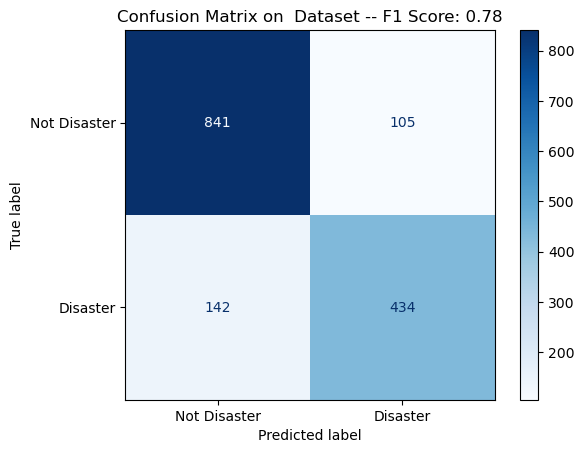

In [36]:
displayConfusionMatrix(preds_ouput.label_ids, preds_ouput.predictions)

/scratch/singularity_webdata_ws01_eastus2_nfs/chec/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


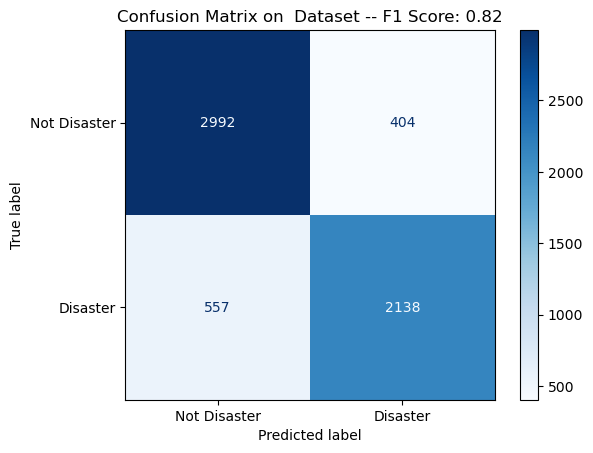

In [37]:
y_pred_train =preds_ouput = trainer.predict(tokenized_dataset_train)

displayConfusionMatrix(y_pred_train.label_ids, y_pred_train.predictions)

# Generate the submission file 

For each tweets in the test set, we predict if the given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

The `submission.csv` file uses the following format:
`id,target`

In [38]:
dataset_test = Dataset.from_pandas(df_test)
tokenized_dataset_test = dataset_test.map(preprocess, remove_columns=['id', 'text', 'keyword', 'location'])

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

In [56]:
test_preds_output = trainer.predict(tokenized_dataset_test)

In [58]:
sample_submission = pd.read_csv(INPUT_PREFIX + "sample_submission.csv")
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [59]:
sample_submission["target"] = (test_preds_output.predictions > 0.5).astype(np.int16)

In [63]:
sample_submission.target.value_counts()

0    1918
1    1345
Name: target, dtype: int64

In [ ]:
sample_submission.to_csv("submission.csv", index=False)